In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.modules.plotting_scripts import plot_surprisals, get_avg_df, plot_avg_pos_neg

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict

def trend_categories(df, first_step=True):

    def determine_trend(values):
        X = np.arange(len(values)).reshape(-1, 1)
        model = LinearRegression().fit(X, values)
        slope = model.coef_[0]
        return '\u2197' if slope > 0 else '\u2198'

    categories = defaultdict(lambda: [0, []])

    if not first_step:
        df = df[df['Steps'] != 0]
        
    grouped = df.groupby('Token')
    
    for word, word_data in grouped:
        surprisal_values = word_data['MeanSurprisal'].values.reshape(-1, 1)
        antisurprisal_values = word_data['MeanAntisurprisal'].values.reshape(-1, 1)
        
        surprisal_trend = determine_trend(surprisal_values)
        antisurprisal_trend = determine_trend(antisurprisal_values)
        
        key = f"{surprisal_trend} Surprisal - {antisurprisal_trend} Anti-surprisal"
        categories[key][0] += 1
        categories[key][1].append(word)
    
    return categories


In [4]:
path = 'results/surp-antisurp.txt'
surprisals = pd.read_csv(path, delimiter='\t')
surprisals

,Steps,Token,MedianRank,MeanSurprisal,StdevSurprisal,MeanAntisurprisal,StdevAntisurprisal,Accuracy,NumExamples
0,0,is,24756,15.723553,0.387810,15.719462,0.386765,0.0,512
1,0,an,25661,15.710485,0.390532,15.688513,0.393345,0.0,512
2,0,english,16640,14.988935,0.577674,14.871839,0.543091,0.0,31
3,0,film,10210,14.798648,0.381293,14.791346,0.379303,0.0,157
4,0,television,13989,15.037534,0.374130,15.000307,0.430571,0.0,29
...,...,...,...,...,...,...,...,...,...
271754,2000000,truths,0,0.980056,NaN,29.890131,NaN,1.0,1
271755,2000000,echoing,14,7.927981,NaN,21.628633,NaN,0.0,1
271756,2000000,culturally,0,0.001594,NaN,29.896456,NaN,1.0,1
271757,2000000,genres,0,0.728909,NaN,21.989182,NaN,1.0,1


In [5]:
# example_counts = indiv_surprisals[indiv_surprisals.Steps == 0].Token.value_counts()
# print(f"Maximum number of examples: {example_counts.max()}")
# print(f"Minimum number of examples: {example_counts.min()}")
# print(f"Average number of examples: {example_counts.mean()}")

In [6]:
# example_counts = example_counts.reset_index().rename(columns={'count': 'Frequency'})

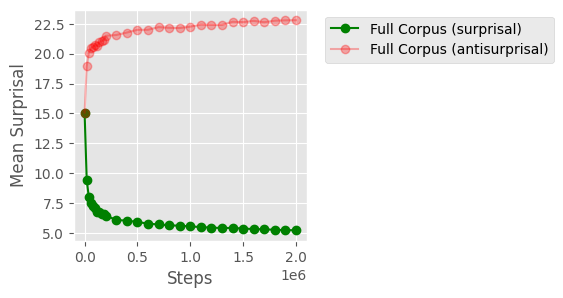

In [7]:
positives = get_avg_df([surprisals], column='MeanSurprisal')
negatives = get_avg_df([surprisals], column='MeanAntisurprisal')

plot_avg_pos_neg(positives, negatives)

In [8]:
# surprisals = indiv_surprisals[['Steps', 'Token', 'MeanSurprisal', 'MeanNegSurprisal']].drop_duplicates().reset_index(drop=True)
# surprisals = surprisals.merge(example_counts)
# surprisals

In [74]:
categories = trend_categories(surprisals)
categories_df = pd.DataFrame(categories, index=['count', 'words']).transpose()

num_tokens = surprisals.Token.nunique()
categories_df['overall_prop (%)'] = categories_df['count'].apply(lambda x: round((x * 100) / num_tokens, 1))
categories_df = categories_df.reset_index().rename(columns={'index': 'trend_category'})
categories_df

,trend_category,count,words,overall_prop (%)
0,↘ Surprisal - ↗ Anti-surprisal,8539,"[a, aa, abandon, abandoned, abandoning, abando...",91.1
1,↘ Surprisal - ↘ Anti-surprisal,521,"[abbreviation, aboriginal, acclaimed, accord, ...",5.6
2,↗ Surprisal - ↗ Anti-surprisal,284,"[absorption, accelerating, accessibility, acci...",3.0
3,↗ Surprisal - ↘ Anti-surprisal,27,"[autobiographical, autonomous, basins, broadca...",0.3


---
### Investigating the effect of **token frequency**

In [75]:
infreq_tokens = surprisals[surprisals.NumExamples <= 10].Token.unique()
print(f"Number of infrequent (frequency ≤ 10) tokens in the word bank: {len(infreq_tokens)}")

Number of infrequent (frequency ≤ 10) tokens in the word bank: 7458


In [76]:
# proportion of the category covered by infrequent tokens
categories_df['cat_coverage (%)'] = categories_df.words.apply(lambda x: round(len((set(x).intersection(infreq_tokens))) * 100 / len(x), 1))

# proportion (distribution) of infrequent tokens in each category
categories_df['infreq_prop (%)'] = categories_df.words.apply(lambda x: round(len((set(x).intersection(infreq_tokens))) * 100 / len(infreq_tokens), 1))

categories_df

,trend_category,count,words,overall_prop (%),cat_coverage (%),infreq_prop (%)
0,↘ Surprisal - ↗ Anti-surprisal,8539,"[a, aa, abandon, abandoned, abandoning, abando...",91.1,77.6,88.9
1,↘ Surprisal - ↘ Anti-surprisal,521,"[abbreviation, aboriginal, acclaimed, accord, ...",5.6,100.0,7.0
2,↗ Surprisal - ↗ Anti-surprisal,284,"[absorption, accelerating, accessibility, acci...",3.0,99.3,3.8
3,↗ Surprisal - ↘ Anti-surprisal,27,"[autobiographical, autonomous, basins, broadca...",0.3,100.0,0.4


In [ ]:
def calculate_stats(word_list, word_freqs_df):
    frequencies = word_freqs_df[word_freqs_df['Token'].isin(word_list)]['NumExamples']
    return pd.Series([int(frequencies.min()), int(frequencies.max()), int(frequencies.median()), round(frequencies.mean())],
                     index=['min_freq', 'max_freq', 'median_freq', 'rounded_mean_freq'])

categories_df[['min_freq', 'max_freq', 'median_freq', 'rounded_avg_freq']] = categories_df['words'].apply(
    lambda words: calculate_stats(words, surprisals)
)

# categories_df.to_csv('results/surp_antisurp_trends.csv', index=None)
categories_df

,trend_category,count,words,overall_prop (%),cat_coverage (%),infreq_prop (%),min_freq,max_freq,median_freq,rounded_avg_freq
0,↘ Surprisal - ↗ Anti-surprisal,8539,"[a, aa, abandon, abandoned, abandoning, abando...",91.1,77.6,88.9,1,512,4,13
1,↘ Surprisal - ↘ Anti-surprisal,521,"[abbreviation, aboriginal, acclaimed, accord, ...",5.6,100.0,7.0,1,9,1,2
2,↗ Surprisal - ↗ Anti-surprisal,284,"[absorption, accelerating, accessibility, acci...",3.0,99.3,3.8,1,18,1,1
3,↗ Surprisal - ↘ Anti-surprisal,27,"[autobiographical, autonomous, basins, broadca...",0.3,100.0,0.4,1,3,1,1


In [78]:
overall_prop = categories_df[['trend_category', 'overall_prop (%)', 'cat_coverage (%)', 'infreq_prop (%)']]
overall_prop

,trend_category,overall_prop (%),cat_coverage (%),infreq_prop (%)
0,↘ Surprisal - ↗ Anti-surprisal,91.1,77.6,88.9
1,↘ Surprisal - ↘ Anti-surprisal,5.6,100.0,7.0
2,↗ Surprisal - ↗ Anti-surprisal,3.0,99.3,3.8
3,↗ Surprisal - ↘ Anti-surprisal,0.3,100.0,0.4


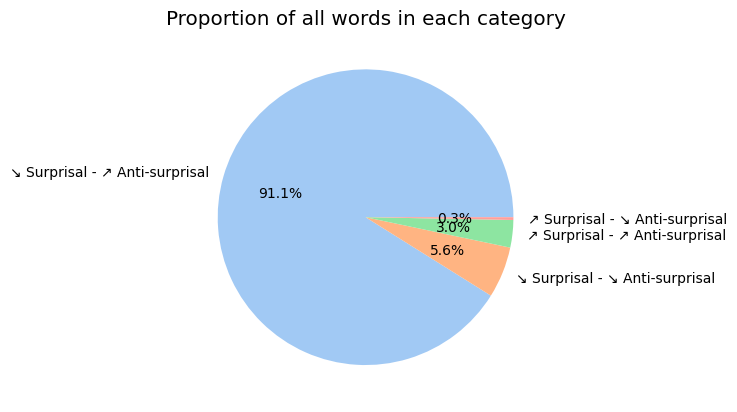

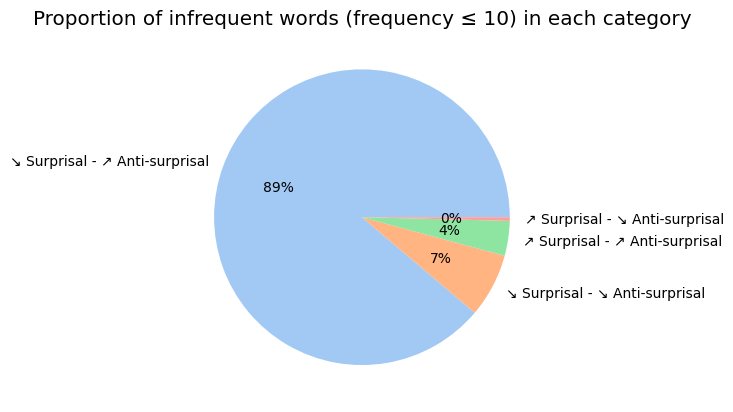

In [79]:
colors = sns.color_palette('pastel')[0:4]

plt.pie(categories_df['overall_prop (%)'], labels=categories_df['trend_category'], colors=colors, autopct='%.1f%%')
plt.title('Proportion of all words in each category')
plt.show()

plt.pie(categories_df['infreq_prop (%)'], labels=categories_df['trend_category'], colors=colors, autopct='%.f%%')
plt.title('Proportion of infrequent words (frequency ≤ 10) in each category')
plt.show()

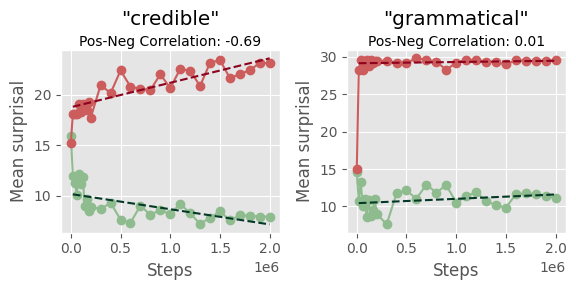

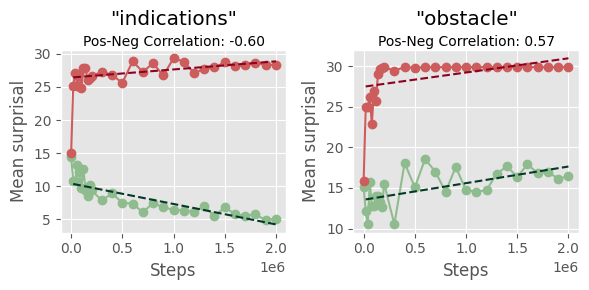

In [ ]:
# Decreasing-Increasing: 'flesh'/'banned'/'regain'/'heating', 
# Increasing-Decreasing: 'comical'/'jewellery'/'outdoor'/'grammatical'
# Decreasing-Decreasing: 'creature'/'indications'
# Increasing-Increasing: 'neighbourhoods'/'silly'/'brow'/'predictions'/'obstacle'

words = ['credible', 'grammatical']
plot_surprisals(words, surprisals, show_error_interval=False, plot_antisurprisal=True, fit_line=True, first_step=False, legend=False) 
words = ['indications', 'obstacle']
plot_surprisals(words, surprisals, show_error_interval=False, plot_antisurprisal=True, fit_line=True, first_step=False, legend=False)

---
### Investigating the effect of **POS** 

In [ ]:
# Run to add a POS column to the surprisals file

# from src.modules import POS

# create new POS tags from a given text file
# document = "data/raw/wikitext103_test.txt"
# pos_tags = POS.get_tags(document)
# merged_df = pd.merge(surprisals, pos_tags, on='Token', how='inner')

# or retrieve POS tags from the word bank
# wordbank = pd.read_json('data/processed/wordbank.jsonl', lines=True)[['token', 'POS']]
# merged_df = pd.merge(surprisals, wordbank, left_on='Token', right_on='token').drop(columns=['token'])

# merged_df.to_csv('results/surprisals_pos.tsv', sep='\t', index=False)

In [83]:
surprisals_pos = pd.read_csv('results/surprisals_pos.tsv', sep='\t')
surprisals_pos

,Steps,Token,MedianRank,MeanSurprisal,StdevSurprisal,MeanAntisurprisal,StdevAntisurprisal,Accuracy,NumExamples,POS
0,0,is,24756,15.723553,0.387810,15.719462,0.386765,0.0,512,"['ADV', 'AUX']"
1,0,an,25661,15.710485,0.390532,15.688513,0.393345,0.0,512,"['DET', 'PROPN']"
2,0,english,16640,14.988935,0.577674,14.871839,0.543091,0.0,31,"['ADJ', 'PROPN']"
3,0,film,10210,14.798648,0.381293,14.791346,0.379303,0.0,157,"['VERB', 'NOUN', 'PROPN']"
4,0,television,13989,15.037534,0.374130,15.000307,0.430571,0.0,29,"['NOUN', 'PROPN']"
...,...,...,...,...,...,...,...,...,...,...
271754,2000000,truths,0,0.980056,NaN,29.890131,NaN,1.0,1,['NOUN']
271755,2000000,echoing,14,7.927981,NaN,21.628633,NaN,0.0,1,['VERB']
271756,2000000,culturally,0,0.001594,NaN,29.896456,NaN,1.0,1,['ADV']
271757,2000000,genres,0,0.728909,NaN,21.989182,NaN,1.0,1,['NOUN']


In [84]:
categories = trend_categories(surprisals_pos)
categories_df_1 = pd.DataFrame(categories, index=['count', 'words']).transpose()

num_tokens = surprisals_pos.Token.nunique()
categories_df_1['overall_prop'] = categories_df_1['count'].apply(lambda x: round((x * 100) / num_tokens, 1))
categories_df_1 = categories_df_1.reset_index().rename(columns={'index': 'trend_category'})
categories_df_1

,trend_category,count,words,overall_prop
0,↘ Surprisal - ↗ Anti-surprisal,8539,"[a, aa, abandon, abandoned, abandoning, abando...",91.1
1,↘ Surprisal - ↘ Anti-surprisal,521,"[abbreviation, aboriginal, acclaimed, accord, ...",5.6
2,↗ Surprisal - ↗ Anti-surprisal,284,"[absorption, accelerating, accessibility, acci...",3.0
3,↗ Surprisal - ↘ Anti-surprisal,27,"[autobiographical, autonomous, basins, broadca...",0.3


In [85]:
categories_df_2 = pd.read_csv('results/surp_antisurp_trends.csv')
categories_df_2

,trend_category,count,words,overall_prop (%),cat_coverage (%),infreq_prop (%),min_freq,max_freq,median_freq,rounded_avg_freq
0,↘ Surprisal - ↗ Anti-surprisal,8539,"['a', 'aa', 'abandon', 'abandoned', 'abandonin...",91.1,77.6,88.9,1,512,4,13
1,↘ Surprisal - ↘ Anti-surprisal,521,"['abbreviation', 'aboriginal', 'acclaimed', 'a...",5.6,100.0,7.0,1,9,1,2
2,↗ Surprisal - ↗ Anti-surprisal,284,"['absorption', 'accelerating', 'accessibility'...",3.0,99.3,3.8,1,18,1,1
3,↗ Surprisal - ↘ Anti-surprisal,27,"['autobiographical', 'autonomous', 'basins', '...",0.3,100.0,0.4,1,3,1,1


In [87]:
import ast
from collections import Counter

# Step 1: Create a mapping of words to their POS tags
word_to_pos = dict(zip(surprisals_pos['Token'], surprisals_pos['POS'].apply(ast.literal_eval)))
word_to_pos

# Step 2: Map tags to each word in `categories_df`
categories_df['tags'] = categories_df['words'].apply(
    lambda words: [tag for word in words if word in word_to_pos for tag in word_to_pos[word]]
)

# Step 3: Calculate total tags for each category
categories_df['total_tags'] = categories_df['tags'].apply(len)

# Step 4: Count individual tag occurrences
categories_df['tag_counts'] = categories_df['tags'].apply(lambda tags: Counter(tags))

# Step 5: Calculate proportions for each tag
unique_tags = set(tag for tags in categories_df['tags'] for tag in tags)
for tag in unique_tags:
    categories_df[tag] = categories_df['tag_counts'].apply(lambda counts: counts.get(tag, 0)) / categories_df['total_tags']

# Drop intermediate columns
categories_df = categories_df.drop(columns=['tags', 'tag_counts', 'total_tags'])

categories_df

,trend_category,count,words,overall_prop (%),cat_coverage (%),infreq_prop (%),min_freq,max_freq,median_freq,rounded_avg_freq,...,NOUN,CCONJ,NUM,INTJ,X,PRON,SCONJ,ADP,ADV,ADJ
0,↘ Surprisal - ↗ Anti-surprisal,8539,"[a, aa, abandon, abandoned, abandoning, abando...",91.1,77.6,88.9,1,512,4,13,...,0.415500,0.000892,0.003300,0.000892,0.001694,0.004013,0.00223,0.006778,0.042094,0.131365
1,↘ Surprisal - ↘ Anti-surprisal,521,"[abbreviation, aboriginal, acclaimed, accord, ...",5.6,100.0,7.0,1,9,1,2,...,0.542169,0.000000,0.003442,0.000000,0.000000,0.001721,0.00000,0.000000,0.022375,0.166954
2,↗ Surprisal - ↗ Anti-surprisal,284,"[absorption, accelerating, accessibility, acci...",3.0,99.3,3.8,1,18,1,1,...,0.481848,0.000000,0.000000,0.000000,0.000000,0.003300,0.00000,0.003300,0.026403,0.161716
3,↗ Surprisal - ↘ Anti-surprisal,27,"[autobiographical, autonomous, basins, broadca...",0.3,100.0,0.4,1,3,1,1,...,0.464286,0.000000,0.035714,0.000000,0.000000,0.000000,0.00000,0.000000,0.035714,0.142857


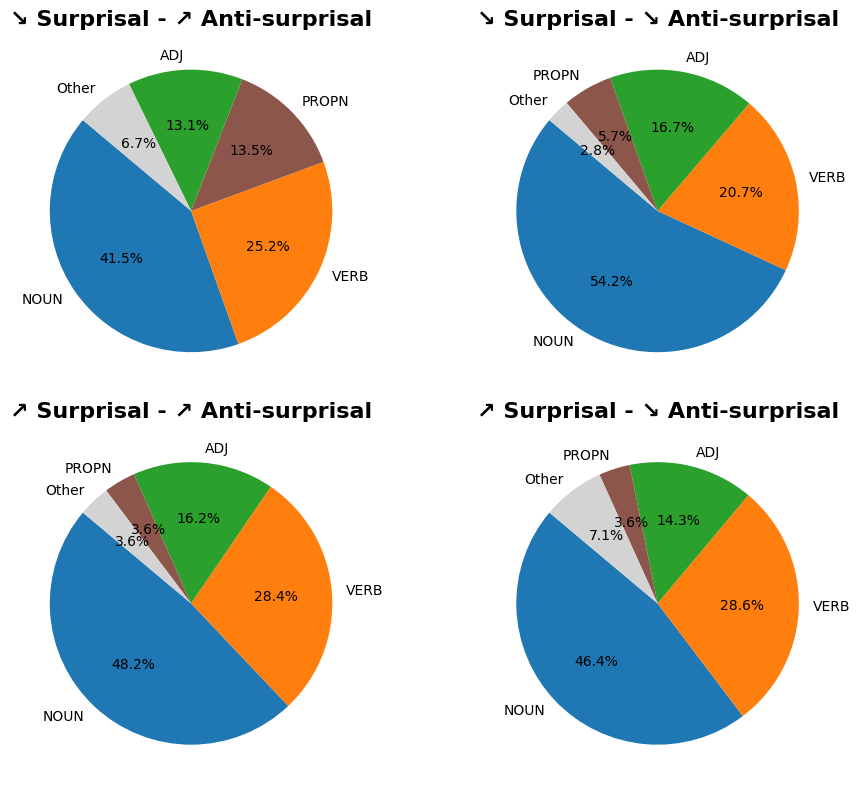

In [88]:
import matplotlib.pyplot as plt

# categories_df = categories_df.loc[['\u2197 Surprisal - \u2197 Anti-surprisal', '\u2198 Surprisal - \u2197 Anti-surprisal', '\u2197 Surprisal - \u2198 Anti-surprisal', '\u2198 Surprisal - \u2198 Anti-surprisal']]

tag_colors = {
    'NOUN': '#1f77b4',
    'VERB': '#ff7f0e',
    'ADJ': '#2ca02c',
    'ADV': '#d62728',
    'DET': '#9467bd',
    'PROPN': '#8c564b',
    'PRON': '#e377c2',
    'ADP': '#7f7f7f',
    'CONJ': '#bcbd22',
    'SCONJ': '#17becf',
    'NUM': '#aec7e8',
    'AUX': '#ffbb78',
    'PART': '#98df8a',
    'INTJ': '#ff9896',
    'X': '#c5b0d5'
}

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easier indexing

for idx, (row, ax) in enumerate(zip(categories_df.iterrows(), axes)):
    category_name = row[1].trend_category
    proportions = {tag: row[1][tag] for tag in unique_tags if row[1][tag] > 0}
    
    # Sort tags by their proportions and highlight the top 4
    sorted_tags = sorted(proportions.items(), key=lambda x: x[1], reverse=True)
    top_tags = dict(sorted_tags[:4])
    other_tags = dict(sorted_tags[4:])
    if other_tags:
        top_tags['Other'] = sum(other_tags.values())

    colors = [tag_colors.get(tag, '#d3d3d3') for tag in top_tags.keys()]  # Default to gray if tag not in tag_colors

    ax.pie(
        top_tags.values(),
        labels=top_tags.keys(),
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
    )
    ax.set_title(f"{category_name}", fontweight='bold', fontsize=16)

plt.tight_layout()
# plt.savefig('img/tag_proportions.pdf', format='pdf', bbox_inches='tight')
plt.show()
